In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates
import sys
sys.path.insert(1, '../../auxiliary_scripts')
from output_postprocessing import parse_methane_series, parse_layer_file, parse_univariate_file

In [46]:
layer_datafile_names={'layers': 'layers  1  1.dat'}

methane_datafile_names={'methane': 'methane_series  1  1.dat'}

univariate_datafile_names = {
                  'water_temp': 'water_temp  1  1f2.dat',
                  'soil_temp': 'soil_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'chla': 'chla  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat',
                  'phosph_water': 'phosph_water  1  1f2.dat',
                  'prodox': 'prodox  1  1f2.dat',
                  'sod': 'sod  1  1f2.dat'} #dead POC

In [47]:
run_path=os.path.join('TKL873/TKL873', 'time_series')
df_layer = parse_layer_file(os.path.join(run_path, layer_datafile_names['layers']))
df_methane = parse_methane_series(os.path.join(run_path, methane_datafile_names['methane']))
df_soil = parse_univariate_file(os.path.join(run_path, univariate_datafile_names['soil_temp']), 'soil_temp')
df_result=pd.DataFrame()
for var_key in univariate_datafile_names:      
        if(len(df_result)==0):
            df_result = parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key)
        else: 
            df_result = pd.merge(df_result, parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key))

In [48]:
df_results_depth_avg = df_result.groupby(by=['Date']).mean().reset_index()

# Water/Soil Layering and Thermal Plots

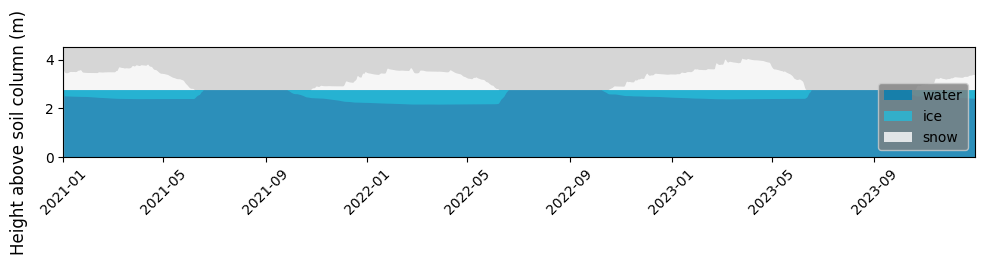

In [13]:
fig, ax = plt.subplots(figsize=(10,2))
    
ax.fill_between(df_layer['Date'], 0, df_layer['water layer thickness, m'],  
                    facecolor ='#027eb3', alpha = 0.8, label='water')
ax.fill_between(df_layer['Date'], df_layer['water layer thickness, m']-df_layer['ice layer thickness,   m'], df_layer['water layer thickness, m'],  
                    facecolor ='#25bbd9', alpha = 0.8, label='ice')
ax.fill_between(df_layer['Date'], df_layer['water layer thickness, m'], df_layer['snow layer thickness,  m'] + df_layer['water layer thickness, m'],  
                    facecolor ='white', alpha = 0.8, label='snow')

ax.set_facecolor('#d6d6d6')

ax.legend(loc='lower right', facecolor = 'grey')
    

plt.ylim(0, 4.5)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime('2021-01-01'),pd.to_datetime('2023-12-31'))
fig.supylabel('Height above soil column (m)')
fig.tight_layout()

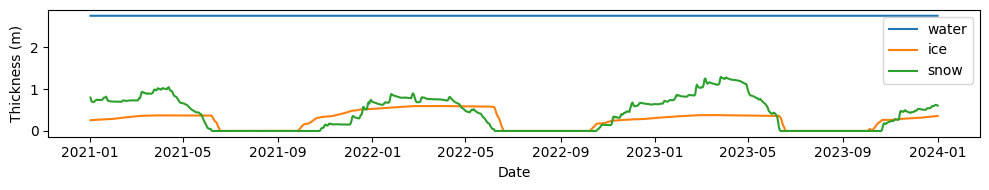

In [17]:
fig, ax = plt.subplots(figsize=(10,2))
sns.lineplot(x=df_layer['Date'], y=df_layer['water layer thickness, m'], ax=ax, label='water')
sns.lineplot(x=df_layer['Date'], y=df_layer['ice layer thickness,   m'], ax=ax, label='ice')
sns.lineplot(x=df_layer['Date'], y=df_layer['snow layer thickness,  m'], ax=ax, label='snow')
ax.set_ylabel('Thickness (m)')
fig.tight_layout()

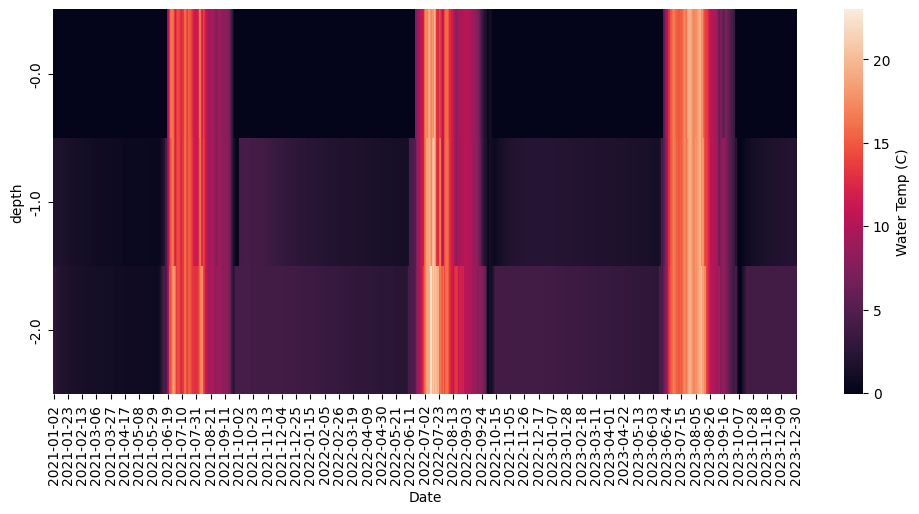

In [37]:
pd.plotting.register_matplotlib_converters()

water_temps_filt=df_result.loc[(df_result['water_temp']!=-999)][['Date', 'depth', 'water_temp']].groupby(by=['Date', 'depth']).mean()
water_temps_filt = water_temps_filt.reset_index()
water_temps_filt['Date'] = pd.to_datetime(water_temps_filt['Date'])
water_temps_filt['Date'] = water_temps_filt['Date'].dt.date


pivot = water_temps_filt.pivot(index='depth', columns='Date', values='water_temp')
fig, ax = plt.subplots(1,1,figsize=(12,5))

sns.heatmap(pivot, cmap='rocket', ax=ax, cbar_kws={'label': 'Water Temp (C)'})

plt.gca().invert_yaxis()

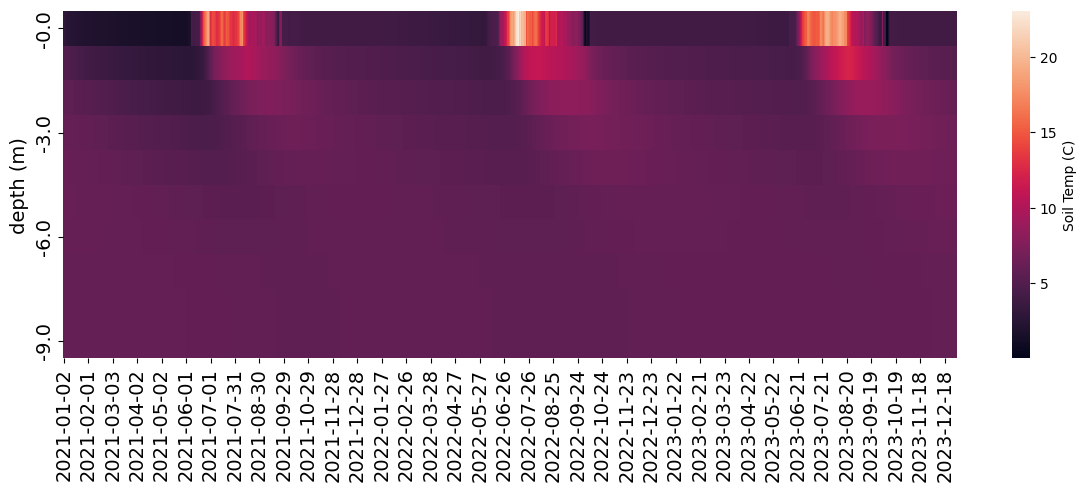

In [34]:
pd.plotting.register_matplotlib_converters()
soil_temps_filt=df_soil.loc[(df_soil['soil_temp']!=-999)][['Date', 'depth', 'soil_temp']].groupby(by=['Date', 'depth']).mean()
soil_temps_filt = soil_temps_filt.reset_index()
soil_temps_filt['Date'] = pd.to_datetime(soil_temps_filt['Date'])
soil_temps_filt['Date'] = soil_temps_filt['Date'].dt.date

pivot = soil_temps_filt.pivot(index='depth', columns='Date', values='soil_temp')

fig, ax = plt.subplots(1,1,figsize=(12,5))

sns.heatmap(pivot, cmap='rocket', ax=ax, xticklabels=30, yticklabels=3, cbar_kws = {'label':'Soil Temp (C)'})
plt.ylabel('depth (m)', fontsize=14)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.gca().invert_yaxis()

fig.tight_layout()




# Biogeochemical Concentrations

Text(0, 0.5, 'SOD\n(mol m-2 s-1)')

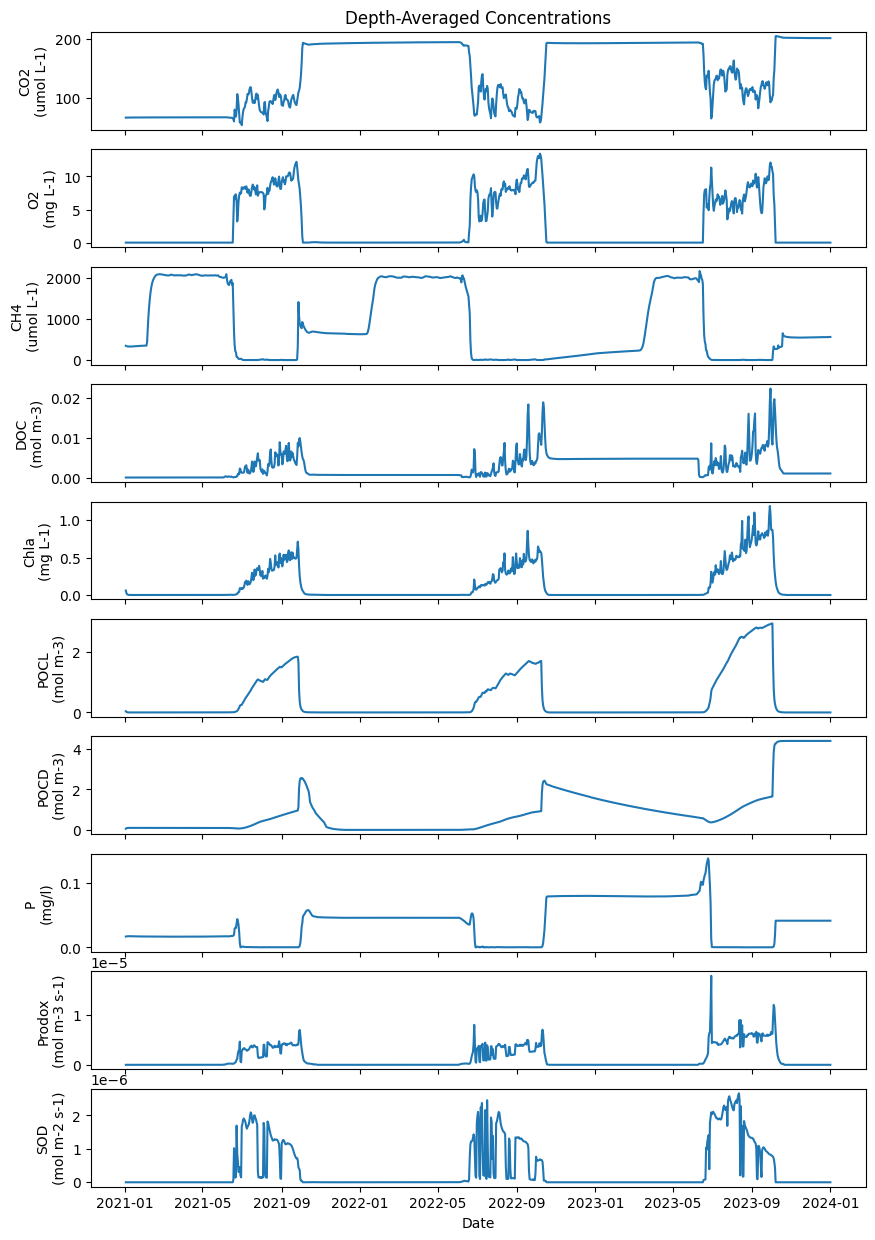

In [53]:
fig, axes = plt.subplots(10, 1,figsize=(10,15), sharex=True)

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='co2_water', ax = axes[0], legend=False)

axes[0].set_title('Depth-Averaged Concentrations')
axes[0].set_ylabel('CO2\n(umol L-1)')

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='o2_water', ax = axes[1])
axes[1].set_ylabel('O2\n(mg L-1)')

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='ch4_water', ax = axes[2], legend=False)
axes[2].set_ylabel('CH4\n(umol L-1)')

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='doc_water', ax = axes[3], legend=False)
axes[3].set_ylabel('DOC\n(mol m-3)')

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='chla', ax = axes[4], legend=False)
axes[4].set_ylabel('Chla\n(mg L-1)')

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='pocl_water', ax = axes[5], legend=False)
axes[5].set_ylabel('POCL\n(mol m-3)')

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='pocd_water', ax = axes[6], legend=False)
axes[6].set_ylabel('POCD\n(mol m-3)')

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='phosph_water', ax = axes[7], legend=False)
axes[7].set_ylabel('P\n(mg/l)')

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='prodox', ax = axes[8], legend=False)
axes[8].set_ylabel('Prodox\n(mol m-3 s-1)')

sns.lineplot(data= df_results_depth_avg, 
                 x='Date', y='sod', ax = axes[9], legend=False)
axes[9].set_ylabel('SOD\n(mol m-2 s-1)')

# CH4 outputs

Text(0, 0.5, 'mgCH4 m-2 d-1')

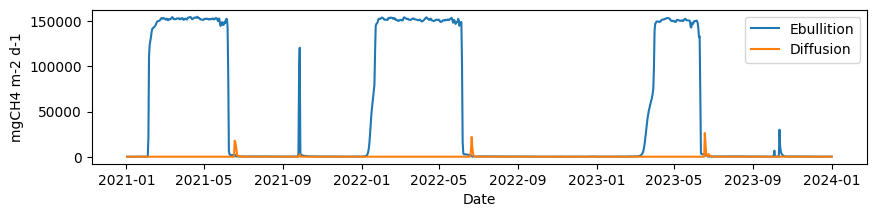

In [62]:
fig, ax = plt.subplots(figsize=(10,2))

sns.lineplot(data=df_methane, x='Date', y='methane_ebul_mg/(m**2*day)', label='Ebullition')
sns.lineplot(data=df_methane, x='Date', y='methane_turb_flux_mg/(m**2*day)', label='Diffusion')

ax.set_ylabel('mgCH4 m-2 d-1')

(0.0, 400.0)

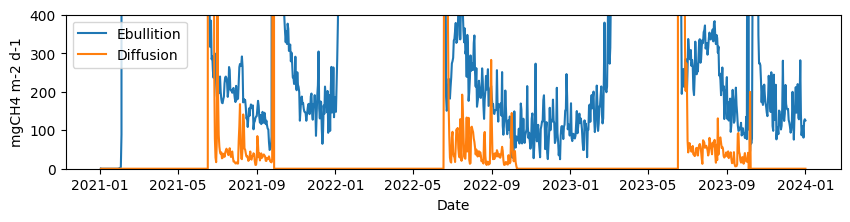

In [64]:
fig, ax = plt.subplots(figsize=(10,2))

sns.lineplot(data=df_methane, x='Date', y='methane_ebul_mg/(m**2*day)', label='Ebullition')
sns.lineplot(data=df_methane, x='Date', y='methane_turb_flux_mg/(m**2*day)', label='Diffusion')

ax.set_ylabel('mgCH4 m-2 d-1')
ax.set_ylim(0,400)

Text(0, 0.5, 'mgCH4 m-2 d-1')

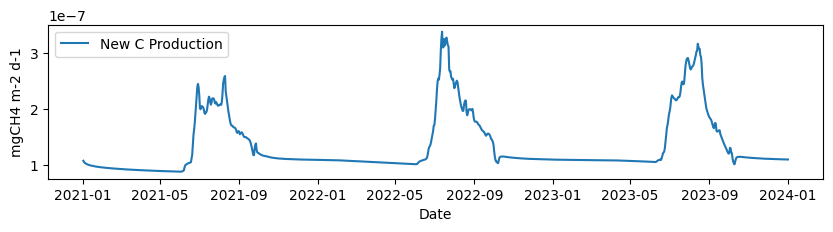

In [70]:
fig, ax = plt.subplots(figsize=(10,2))

sns.lineplot(data=df_methane, x='Date', y='methane_prod_young_mol/(m**2*s)', label='New C Production')


ax.set_ylabel('mgCH4 m-2 d-1')

Text(0, 0.5, 'mgCH4 m-2 d-1')

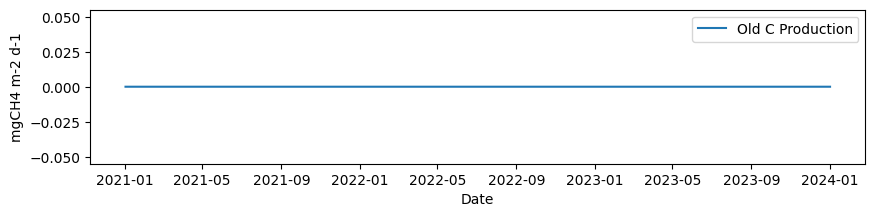

In [71]:
fig, ax = plt.subplots(figsize=(10,2))
sns.lineplot(data=df_methane, x='Date', y='methane_prod_old_mol/(m**2*s)', label='Old C Production')
ax.set_ylabel('mgCH4 m-2 d-1')